In [302]:
import numpy as np
import os
from pathlib import Path


In [303]:
# ex = train_p.glob("*")
# ex

In [304]:
import pandas as pd

X_train_original = pd.read_csv("./Train/train.csv")
# X_train_original = X_train_original.reset_index()  # make sure indexes pair with number of rows
X_train_original.head()

,ImageId,NameOfPokemon
0,296.jpg,Pikachu
1,297.jpg,Pikachu
2,298.jpg,Pikachu
3,299.jpg,Pikachu
4,300.jpg,Pikachu


In [305]:
from keras.preprocessing import image

In [306]:
pokemon_dict = {'Pikachu': 0, 'Bulbasaur': 1, 'Charmander': 2}

In [307]:
X_train_list = []
Y_train_list = []
for imagefileName, label in zip(X_train_original['ImageId'], X_train_original['NameOfPokemon']):
    # print(imagefileName, label)
    filepath =  "" + "./Train/Images/" + imagefileName
    # filename = filename.astype('string')
    # print(type(filepath))
    img = image.load_img(filepath,target_size=(100, 100))
    img_array = image.img_to_array(img)
    X_train_list.append(img_array)
    # print(pokemon_dict[label])
    Y_train_list.append(pokemon_dict[label])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [308]:
print(len(X_train_list))
print(len(Y_train_list))

304
304


In [309]:
X_train_nparr = np.array(X_train_list,dtype='float32')/255 # Otherwise we get this error - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Y_train_nparr = np.array(Y_train_list,dtype='int32')
print(X_train_nparr.shape, Y_train_nparr.shape)


(304, 100, 100, 3) (304,)


In [310]:
def drawImg(img):
    from matplotlib import pyplot as plt
    plt.axis("off")
    plt.imshow(img)
    plt.show()
    return

In [311]:
# Randomly shuffle Train data

import random

print(Y_train_nparr.shape)
print(X_train_nparr.shape)
combined_X_Y_train = list(zip(X_train_nparr, Y_train_nparr)) # list of tuples?
# print(type(combined_X_Y_train))
# print(type(combined_X_Y_train[0]))
# print(type(combined_X_Y_train[0][0]))
# print(type(combined_X_Y_train[0][1]))
# print(combined_X_Y_train[0][0].shape)
# print(combined_X_Y_train[0][0])
# print(combined_X_Y_train[0][1])
random.shuffle(combined_X_Y_train)
X_train_shuffled = np.zeros(X_train_nparr.shape)
Y_train_shuffled = np.zeros(Y_train_nparr.shape)
X_train_shuffled[:], Y_train_shuffled[:] = zip(*combined_X_Y_train)
print(X_train_shuffled.shape)
print(Y_train_shuffled.shape)
print(Y_train_shuffled[0])
Y_train_shuffled = Y_train_shuffled.astype('int32')
print(Y_train_shuffled[0])

(304,)
(304, 100, 100, 3)
(304, 100, 100, 3)
(304,)
0.0
0


In [312]:
# for i in range(10):
#     drawImg(X_train_shuffled[i])

In [344]:
class PegasosSvm:
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeLoss(self, W, b, X, Y):
        loss = 0.0
        # print(f'W = {W.shape}, b = {b}, X = {X.shape}, Y = {Y.shape}')
        loss += 0.5 * np.dot(W, W.T) # W is a row vector
        for example in range(X.shape[0]):
            ti = Y[example] * (np.dot(W, X[example].T) + b)
            # print(f'=======ti={ti}')
            max_err = max(0, (1-ti))
            loss += (self.C * max_err)
        # print(f'loss = {loss}')
        return loss[0][0]
    
    def fit(self, X, Y, batch_size=50, learning_rate=0.0001,maxItr=1000):
        num_features = X.shape[1]
        num_samples = Y.shape[0]
        W = np.zeros((1, num_features))
        bias = 0

        losses = []

        for i in range(maxItr):
            l = self.hingeLoss(W, bias, X, Y)
            losses.append(l)
            ids = np.arange(num_samples)
            np.random.shuffle(ids)
            for batch_start in range(0, num_samples, batch_size):
                # assume 0 gradient when a batch starts processing
                gradw = 0
                gradb = 0

                for example_idx in range(batch_start, batch_start+batch_size):
                    if(example_idx < num_samples):
                        idx = ids[example_idx]
                        ti = Y[idx] * (np.dot(W, X[idx].T) + bias)
                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += self.C * Y[idx] * X[idx] # here Y[idx] is scalar but X[idx] is a row of features
                            gradb += self.C * Y[idx]
                
                W = W - learning_rate * W + learning_rate * gradw
                bias = bias + learning_rate * gradb
                # print(losses)

        self.W = W
        self.b = bias
        return W, bias, losses




In [345]:
# One-for-one data classification

# Since SVM is a binary classifier, we need to convert data for one-for-one classification

CLASSES = np.unique(Y_train_shuffled)
print(CLASSES)



[0 1 2]


In [346]:
X_train_shuffled_reshaped = X_train_shuffled.reshape((X_train_shuffled.shape[0],-1))
print(X_train_shuffled_reshaped.shape)

(304, 30000)


In [347]:
def classWiseData(x, y):

    data = {}
    for i in range(len(CLASSES)):
        data[i] = []
    for ex in range(x.shape[0]):
        data[y[ex]].append(x[ex])
    for k in data.keys():
        data[k] = np.array(data[k])
    return data


In [348]:
def getdataPairForPegasosSVM(d1, d2):
    numSamples = d1.shape[0] + d2.shape[0]
    numFeatures = d1.shape[1]
    x = np.zeros((numSamples,numFeatures))
    y = np.zeros((numSamples,1))
    x[:d1.shape[0],:] = d1
    x[d1.shape[0]:,:] = d2
    y[:d1.shape[0]] = -1
    y[d1.shape[0]:] = +1
    return x, y

In [349]:
print(X_train_shuffled_reshaped.shape)
print(Y_train_shuffled.shape)
X_train_data = classWiseData(X_train_shuffled_reshaped, Y_train_shuffled)
print(X_train_data[0].shape)
print(X_train_data[1].shape)
print(X_train_data[2].shape)

(304, 30000)
(304,)
(101, 30000)
(101, 30000)
(102, 30000)


In [350]:

mySVM = PegasosSvm()
def trainSVMs():
    svm_classifiers = {}
    for i in range(len(CLASSES)):
        svm_classifiers[i] = {}
        for j in range(i+1, len(CLASSES)):
            x, y = getdataPairForPegasosSVM(X_train_data[i], X_train_data[j])
            print(f'Combination[{i}][{j}]={x.shape} and {y.shape}')
            wts, bias, loss = mySVM.fit(x, y)
            svm_classifiers[i][j] = (wts, bias)
            print(f'Loss[{i}][{j}]={loss}')

    return svm_classifiers



In [351]:
svm_classifiers = trainSVMs()

Combination[0][1]=(202, 30000) and (202, 1)
Loss[0][1]=[202.0, 1021.7025165719798, 1359.7420632317921, 29.394288824938684, 559.1431221118071, 1059.7306095048878, 125.77046663643229, 603.4200670521664, 183.40759782803565, 19.020406229471973, 15.948879789629935, 11.132173517488988, 10.113966073785125, 7.473638419476048, 5.811015135509919, 4.321595926494441, 3.219027022746388, 6.635518402719749, 1.1446940950797768, 0.8233747328319956, 1.3518077635897792, 0.23261389900190912, 0.23238138975125305, 0.23214911290524626, 0.2319170682315888, 0.23168525549821276, 0.2314536744732822, 0.23122232492519285, 0.23099120662257205, 0.23076031933427826, 0.23052966282940132, 0.2302992368772615, 0.23006904124740973, 0.22983907570962744, 0.22960934003392602, 0.2293798339905469, 0.22915055734996084, 0.2289215098828684, 0.2286926913601992, 0.22846410155311178, 0.22823574023299353, 0.22800760717146012, 0.22777970214035576, 0.2275520249117526, 0.22732457525795055, 0.2270973529514773, 0.22687035776508774, 0.2266

In [352]:

print(svm_classifiers[0][1])
print(svm_classifiers[0][1][0].shape)

(array([[ 0.00032849, -0.00021597, -0.00139997, ...,  0.00037741,
         0.00016335, -0.00222189]]), array([0.009]))
(1, 30000)


In [353]:
def binaryPredict(x, w, b):
    z = np.dot(x,w.T) *  b
    if z >= 0:
        return 1
    else:
        return -1

In [354]:
def predict(x):
    count = np.zeros((len(CLASSES),1))
    for i in range(len(CLASSES)):
        for j in range(i+1, len(CLASSES)):
            w,b = svm_classifiers[i][j]
            z = binaryPredict(x,w,b)
            if(z == 1):
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

In [355]:
def accuracy(x,y):
    count = 0
    for ex in range(x.shape[0]):
        prediction = predict(x[ex])
        if(prediction == y[ex]):
            count += 1
    return count/x.shape[0]

In [356]:
accuracy(X_train_shuffled_reshaped,Y_train_shuffled)

1.0

In [357]:

import matplotlib.pyplot as plt

In [358]:
data1, data2 = getdataPairForPegasosSVM(X_train_data[0], X_train_data[1])
w, b, loss = mySVM.fit(data1, data2, learning_rate=0.00001,maxItr=1000)
# plt.plot(loss)

[202.0, 214.86216181507925, 250.57999041090088, 172.91848404447973, 247.4184286192927, 137.00304696830753, 111.4575443604736, 187.27834908922657, 69.29625306814812, 141.4709643660254, 65.966960084906, 76.99003346162174, 20.760200157403098, 29.540656105437062, 40.17768685893271, 22.027070388820853, 22.156358081602296, 38.155244939755455, 41.144983462392624, 12.691207027314622, 43.353571161401284, 16.99569651488914, 9.289303660124482, 7.8073098925716256, 7.928394992955855, 31.4073136749071, 6.869188971340002, 5.815532691332859, 13.51733919917698, 5.695946356498911, 26.01666565242475, 4.6609121218344685, 15.923054214319606, 4.2061303465255895, 9.987686418573254, 11.572040819341783, 4.008923707472335, 6.3807771754538205, 3.7556656376732613, 4.056045954060909, 6.615895187817426, 3.245728867526882, 3.4062215515505505, 4.064487960594239, 5.74382739689589, 2.868943512716287, 7.7940036492073395, 2.736171796760401, 2.8072813495057933, 2.6066779433442973, 2.4020150852628444, 2.4203056477699953, 1

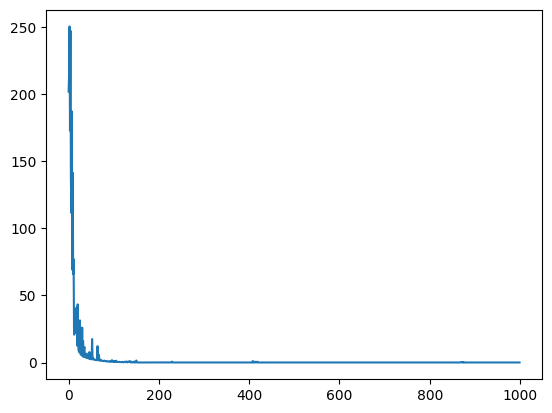

In [359]:
print(loss)
plt.plot(loss)

In [363]:
test_p = Path("./Test/Images/") # Get Path Object
imagefiles = test_p.glob("*") # Gives generator object to Look for "*"" files in this path
print(test_p)
X_test_list = []
for file in imagefiles:
    # print(file)
    img = image.load_img(file,target_size=(100, 100))
    img_array = image.img_to_array(img)
    X_test_list.append(img_array)
X_test_nparr = np.array(X_test_list,dtype='float32')/255
print(X_test_nparr.shape)
# for i in range(10):
#     drawImg(Y_test_nparr[i])
X_test_reshaped = X_test_nparr.reshape((X_test_nparr.shape[0],-1))
print(X_test_reshaped.shape)
result = []
for ex in range(X_test_reshaped.shape[0]):
    prediction = predict(X_test_reshaped[ex])
    result.append(prediction)

result

Test/Images
(123, 100, 100, 3)
(123, 30000)


[1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 2]

In [380]:
class_pokemon_dict = {0: 'Pikachu', 1: 'Bulbasaur', 2:'Charmander'}
X_test_list = []
X_test_df = pd.read_csv("./Test/Sample_submission.csv")
pred_df = pd.DataFrame(X_test_df)
idx = 0
for imagefileName in X_test_df['ImageId']:
    X_test_list = []
    filepath = './Test/Images/' + imagefileName
    img = image.load_img(filepath,target_size=(100, 100))
    img_array = image.img_to_array(img)
    X_test_list.append(img_array)
    X_test_nparr = np.array(X_test_list,dtype='float32')/255
    X_test_reshaped = X_test_nparr.reshape((X_test_nparr.shape[0],-1))
    print(X_test_reshaped.shape)
    print(class_pokemon_dict[prediction])
    prediction = predict(X_test_reshaped)
    pred_df.loc[idx,'NameOfPokemon'] = class_pokemon_dict[prediction]
    idx += 1

pred_df

(1, 30000)
Pikachu
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Pikachu
(1, 30000)
Pikachu
(1, 30000)
Pikachu
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Charmander
(1, 30000)
Pikachu
(1, 30000)
Charmander
(1, 30000)
Pikachu
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Pikachu
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Pikachu
(1, 30000)
Pikachu
(1, 30000)
Pikachu
(1, 30000)
Pikachu
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Pikachu
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1, 30000)
Pikachu
(1, 30000)
Charmander
(1, 30000)
Charmander
(1, 30000)
Bulbasaur
(1, 30000)
Charmander
(1,

,ImageId,NameOfPokemon
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Charmander
4,2011.jpg,Pikachu
...,...,...
118,1124.jpg,Bulbasaur
119,2014.jpg,Pikachu
120,2235.jpg,Charmander
121,1126.jpg,Bulbasaur


In [383]:

# pred_df.reset_index(inplace=True)
# df.set_index('Id', inplace=True)
pred_df.reset_index(drop=True)
# pred_df.set_index(['Id'], inplace=True)
pred_df.head(10)

,ImageId,NameOfPokemon
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Charmander
4,2011.jpg,Pikachu
5,2030.jpg,Pikachu
6,2035.jpg,Pikachu
7,1110.jpg,Bulbasaur
8,1104.jpg,Bulbasaur
9,2217.jpg,Charmander


In [388]:
pred_df.to_csv('./Test/NewResult.csv',index=False)